In [20]:
from simple_unet_model import unet_model  
import keras
from keras_preprocessing import image
from keras.utils.np_utils import normalize
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

In [21]:
SIZE_X = 128 
SIZE_Y = 128
n_classes=10 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("E:/Unet/generated_images/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("E:/Unet/generated_images/labels/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_images.shape)
print(train_masks.shape)
print(np.unique(train_masks))


(2000, 128, 128)
(2000, 128, 128)
[0 1 2 3 4 5 6 7 8 9]


In [22]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks, axis=3)

print(train_images.shape)
print(train_masks_input.shape)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.25, random_state=2)

print("Class values in the dataset are ... ", np.unique(y_train))

(2000, 128, 128, 1)
(2000, 128, 128, 1)
Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [23]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
print(train_masks_cat.shape)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
print(test_masks_cat.shape)

(1600, 128, 128, 10)
(400, 128, 128, 10)


In [24]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [26]:
# Adding data augmentation
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.01,
                    #  zoom_range=[0.9, 1.25],
                     horizontal_flip=True,
                     vertical_flip=True)
                    #  fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train, augment=True, seed=1)
mask_datagen.fit(y_train, augment=True, seed=1)

image_generator = image_datagen.flow(X_train, batch_size=16, seed=1)
mask_generator = mask_datagen.flow(train_masks_cat, batch_size=16, seed=1)
# print(image_generator.shape)
train_generator = zip(image_generator, mask_generator)

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir="E:/Unet/logs/{}".format('model')),
    ModelCheckpoint('E:/Unet/models/model.h5', verbose=1, save_best_only=True)
]

c:\Users\Admin\miniconda3\envs\tfgpu\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1600, 128, 128, 10) (10 channels).
  warnings.warn(


In [27]:
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 16,
                    epochs=100,
                    validation_data=(X_test, test_masks_cat),
                    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.0666 - accuracy: 0.8158
Epoch 1: val_loss improved from inf to 0.87696, saving model to E:/Unet/models\model.h5
100/100 [==============================] - 34s 302ms/step - loss: 1.0666 - accuracy: 0.8158 - val_loss: 0.8770 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8970
Epoch 2: val_loss improved from 0.87696 to 0.54277, saving model to E:/Unet/models\model.h5
100/100 [==============================] - 31s 309ms/step - loss: 0.4122 - accuracy: 0.8970 - val_loss: 0.5428 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9006
Epoch 3: val_loss improved from 0.54277 to 0.42939, saving model to E:/Unet/models\model.h5
100/100 [==============================] - 33s 330ms/step - loss: 0.3192 - accuracy: 0.9006 - val_loss: 0.4294 - val_accuracy: 0.8807 - lr: 0.0

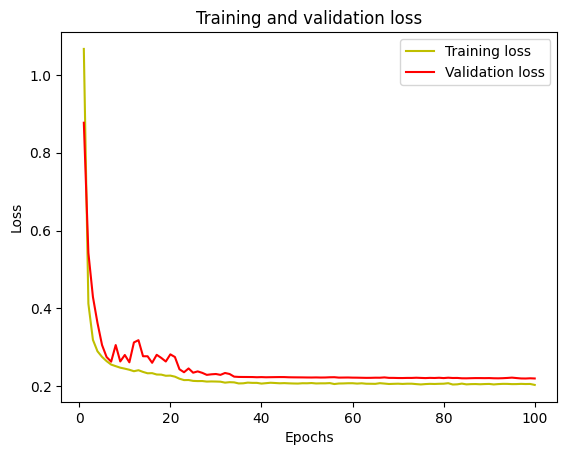

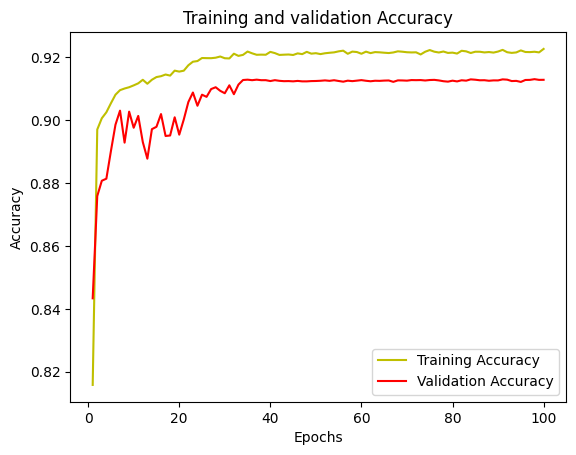

In [28]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('results/Training_&_Validation_Loss.png')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('results/Training_&_Validation_Accuracy.png')
plt.show()

In [29]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = n_classes
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

13/13 [==============================] - 2s 103ms/step
Mean IoU = 0.21834621


1/1 [==============================] - 0s 80ms/step


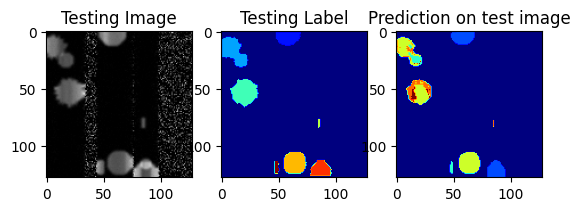

In [30]:
#Testing image
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure()
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.savefig('results/Prediction.png')
plt.show()